## Offensive Language Identification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install unidecode

     |████████████████████████████████| 245kB 21.8MB/s 


In [ ]:
import keras 
keras.__version__

'2.4.3'

In [ ]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 19.0MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
!pip install tensorflow-gpu==1.15.0

     |████████████████████████████████| 411.5MB 43kB/s 
     |████████████████████████████████| 3.8MB 40.3MB/s 
     |████████████████████████████████| 512kB 50.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=8bbf1d0505081e2dba812b6db36e6d6a061b51124494bdfd9a220da812e509fe
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard

In [ ]:
!pip install emoji

     |████████████████████████████████| 133kB 18.2MB/s 


In [ ]:
import os
import time
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model
from keras.engine import Layer
#from keras.models import *
from keras.layers import Input, Embedding, Dense, Flatten, Activation, Dropout, SpatialDropout1D, GRU, Bidirectional, LSTM, BatchNormalization
#from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf
import emoji
from emoji import UNICODE_EMOJI

np.random.seed(42)


Using TensorFlow backend.



### Loading the training and testing files

In [ ]:
train_data = pd.read_csv("./drive/MyDrive/nlp595/Data/training/offenseval-training-v1.tsv", sep='\t')

x_test = pd.read_csv("./drive/MyDrive/nlp595/Data/testing/testset-taska.tsv", sep='\t')
y_test = pd.read_csv("./drive/MyDrive/nlp595/Data/testing/labels-test-a.csv", names = ["id", "subtask_a"])

test_data = pd.merge(x_test, y_test, on=['id','id'])
print("Shape of the training data : ", train_data.shape)
print("Shape of the testing data : ", test_data.shape)

Shape of the training data :  (13240, 5)
Shape of the testing data :  (860, 3)


The embedded matrix has only lowercase words. Hence, we convert the data to lowercase. 

In [ ]:
train_data["tweet"] = train_data["tweet"].str.lower()
test_data["tweet"] = test_data["tweet"].str.lower()

In [ ]:
import string
def sepa_punc(x):
    puncts = string.punctuation 

    for p in puncts:
        x = x.replace(p, f' {p} ')
    return x


train_data["tweet"] = train_data["tweet"].apply(lambda x: sepa_punc(x))
test_data["tweet"] = test_data["tweet"].apply(lambda x: sepa_punc(x))

In [ ]:
!pip install emoji

In [ ]:
def is_emoji(s):
    return s in UNICODE_EMOJI

def sepa_emoji(text):
    res = ''
    for c in text:
      if is_emoji(c):
        res += ' ' 
      res += c
    return res.strip()

train_data["tweet"] = train_data["tweet"].apply(lambda x: sepa_emoji(x))
test_data["tweet"] = test_data["tweet"].apply(lambda x: sepa_emoji(x))

visualize word distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


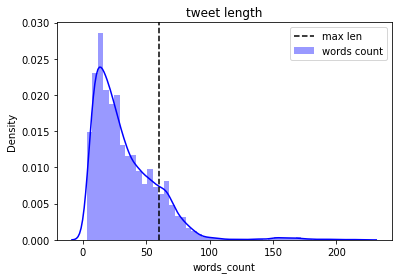

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

train_data['words_count'] = train_data["tweet"].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_data['words_count'].mean() + train_data['words_count'].std()).astype(int)
sns.distplot(train_data['words_count'], hist=True, kde=True, color='b', label='words count')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('tweet length'); plt.legend()
plt.show()

In [ ]:
embedding_size = 300 #Size of a word vector
max_features = None
max_len =  max_seq_len
x_train = train_data['tweet'].fillna("_na_").values
x_test = test_data['tweet'].fillna("_na_").values
tokenizer = Tokenizer(num_words=max_features, filters = '')
tokenizer.fit_on_texts(list(x_train))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen = max_len)
x_test = pad_sequences(x_test, maxlen= max_len)

y_train = train_data['subtask_a'].values

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(y_train)
labels = label_encoder.transform(y_train)


Load the embeddings

In [ ]:
word_index = tokenizer.word_index
max_features = len(word_index) + 1 

emoji_embedding_path = './drive/MyDrive/emoji_embeddings_300d.txt'
word_embedding_path = './drive/MyDrive/crawl-300d-2M-subword.vec'

'''def get_coefficients(word,*array): 
  return word, np.asarray(array, dtype='float32')

def load_word_embedding(word_index):
  enbedding_index = dict(get_coefficients(*o.split(" ")) for o in open(word_embedding_path, encoding="utf8" ) if o.split(" ")[0] in word_index)  
  print(embedding_index)
  return embedding_index

def load_emoji_embedding(word_index):
  enbedding_index = dict(get_coefficients(*o.split(" ")) for o in open(emoji_embedding_path, encoding="utf8" ) if o.split(" ")[0] in word_index)  
  print(embedding_index)
  return embedding_index'''

def load_emoji_embedding(word_index):  
  def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
  embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(emoji_embedding_path, encoding="utf8" ) if o.split(" ")[0] in word_index)  
  return embeddings_index

def load_word_embedding(word_index): 
    def get_coefs(word,*arr): 
      return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(word_embedding_path, encoding="utf8") if o.split(" ")[0] in word_index)
    return embeddings_index



In [ ]:
# word and emoji embeddings in a single matrix with priority on word
def get_emb_matrix_wordemoji(word_index):
    word_embeddings_index = load_word_embedding(word_index)
    emoji_embeddings_index = load_emoji_embedding(word_index)

    word_embs = np.stack(word_embeddings_index.values() )
    emoji_embs = np.stack(emoji_embeddings_index.values() )
    all_embs = np.concatenate((word_embs, emoji_embs))   
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embedding_size = all_embs.shape[1]
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embedding_size))
    
    for word, i in word_index.items():
        if i >= max_features: 
          continue
        embedding_vector = word_embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = emoji_embeddings_index.get(word) 
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    
    return embedding_matrix
    

Get customized embedding matrix

In [ ]:
# embedding_matrix = get_emb_matrix_word(word_index)
embedding_matrix = get_emb_matrix_wordemoji(word_index)
# embedding_matrix = get_emb_matrix_emojiword(word_index)

# embedding_matrix, emoji_embedding_matrix = get_emb_matrix_word_emoji(word_index)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Definning the Capsule Layer in Keras

In [ ]:
def squash(s, axis=-1):
    squared_s = K.sum(K.square(s), axis=axis, keepdims=True)
    scale = squared_s / (1 + squared_s) / K.sqrt(squared_s + K.epsilon())
    return scale * s

In [ ]:
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        self.W = self.add_weight(name='capsule_kernel',
                                  shape=(1, input_dim_capsule,
                                        self.num_capsule * self.dim_capsule),
                                  # shape=self.kernel_size,
                                  initializer='glorot_uniform',
                                  trainable=True)

    def call(self, u_vecs):
        u_hat_vecs = K.conv1d(u_vecs, self.W)
        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  # shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))  # shape = [None, input_num_capsule, num_capsule]
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = squash(K.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(outputs, u_hat_vecs, [2, 3])
        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

Capsule Layer with a Bi directional GRU. Architecture found in text classification project.

In [ ]:
def capsule():
    K.clear_session()       
    inp = Input(shape=(max_len,))
    x = Embedding(max_features, embedding_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = SpatialDropout1D(rate=0.2)(x)
    x = Bidirectional(GRU(90, return_sequences=True, 
                                kernel_initializer=glorot_normal(seed=12300), recurrent_initializer=orthogonal(gain=1.0, seed=10000)))(x)

    x = Capsule(num_capsule=8, dim_capsule=10, routings=4)(x)
    x = Flatten()(x)

    x = Dense(100, activation="relu", kernel_initializer=glorot_normal(seed=12300))(x)
    x = Dropout(0.12)(x)
    x = BatchNormalization()(x)

    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer=Adam(),
        metrics=['accuracy'])
    return model

In [ ]:
def f1_smart(y_true, y_pred):
    args = np.argsort(y_pred)
    tp = y_true.sum()
    fs = (tp - np.cumsum(y_true[args[:-1]])) / np.arange(y_true.shape[0] + tp - 1, tp, -1)
    res_idx = np.argmax(fs)
    return 2 * fs[res_idx], (y_pred[args[res_idx]] + y_pred[args[res_idx + 1]]) / 2

Training with early stopping and reducing learning rate on plateu. In each fold values for the test set is also predicted, And after the process, predicted values for the test file would be mean from each fold

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 300)           6246300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 60, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 180)           211140    
_________________________________________________________________
capsule_1 (Capsule)          (None, 8, 10)             14400     
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               8100      
__________

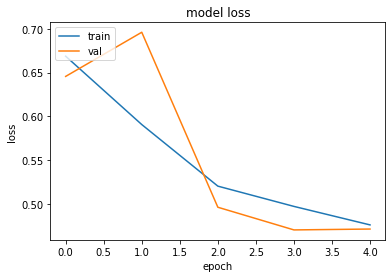

Optimal F1: 0.6949 at threshold: 0.4612
Train on 10592 samples, validate on 2648 samples
Epoch 1/5
 - 25s - loss: 0.6660 - acc: 0.6181 - val_loss: 0.6131 - val_acc: 0.6760

Epoch 00001: val_loss improved from inf to 0.61313, saving model to capsule_net_weights_best.h5
Epoch 2/5
 - 23s - loss: 0.5904 - acc: 0.6906 - val_loss: 0.5423 - val_acc: 0.7289

Epoch 00002: val_loss improved from 0.61313 to 0.54227, saving model to capsule_net_weights_best.h5
Epoch 3/5
 - 23s - loss: 0.5237 - acc: 0.7435 - val_loss: 0.4902 - val_acc: 0.7745

Epoch 00003: val_loss improved from 0.54227 to 0.49015, saving model to capsule_net_weights_best.h5
Epoch 4/5
 - 23s - loss: 0.4883 - acc: 0.7681 - val_loss: 0.4740 - val_acc: 0.7723

Epoch 00004: val_loss improved from 0.49015 to 0.47400, saving model to capsule_net_weights_best.h5
Epoch 5/5
 - 23s - loss: 0.4688 - acc: 0.7812 - val_loss: 0.4652 - val_acc: 0.7779

Epoch 00005: val_loss improved from 0.47400 to 0.46521, saving model to capsule_net_weights_bes

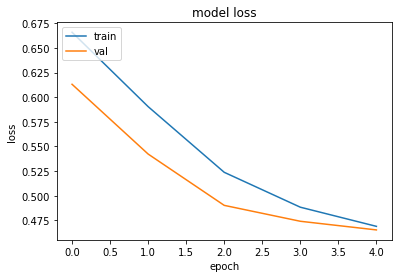

Optimal F1: 0.6789 at threshold: 0.3963
Train on 10592 samples, validate on 2648 samples
Epoch 1/5
 - 24s - loss: 0.6732 - acc: 0.6175 - val_loss: 0.6428 - val_acc: 0.6677

Epoch 00001: val_loss improved from inf to 0.64276, saving model to capsule_net_weights_best.h5
Epoch 2/5
 - 23s - loss: 0.6082 - acc: 0.6774 - val_loss: 0.5671 - val_acc: 0.6847

Epoch 00002: val_loss improved from 0.64276 to 0.56707, saving model to capsule_net_weights_best.h5
Epoch 3/5
 - 23s - loss: 0.5293 - acc: 0.7429 - val_loss: 0.5619 - val_acc: 0.7685

Epoch 00003: val_loss improved from 0.56707 to 0.56186, saving model to capsule_net_weights_best.h5
Epoch 4/5
 - 23s - loss: 0.4896 - acc: 0.7710 - val_loss: 0.4733 - val_acc: 0.7829

Epoch 00004: val_loss improved from 0.56186 to 0.47331, saving model to capsule_net_weights_best.h5
Epoch 5/5
 - 23s - loss: 0.4742 - acc: 0.7819 - val_loss: 0.4662 - val_acc: 0.7810

Epoch 00005: val_loss improved from 0.47331 to 0.46619, saving model to capsule_net_weights_bes

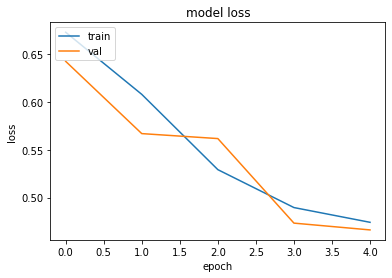

Optimal F1: 0.6866 at threshold: 0.1992
Train on 10592 samples, validate on 2648 samples
Epoch 1/5
 - 25s - loss: 0.6683 - acc: 0.6183 - val_loss: 0.6361 - val_acc: 0.6662

Epoch 00001: val_loss improved from inf to 0.63609, saving model to capsule_net_weights_best.h5
Epoch 2/5
 - 24s - loss: 0.6012 - acc: 0.6828 - val_loss: 0.5522 - val_acc: 0.7141

Epoch 00002: val_loss improved from 0.63609 to 0.55223, saving model to capsule_net_weights_best.h5
Epoch 3/5
 - 23s - loss: 0.5239 - acc: 0.7443 - val_loss: 0.5412 - val_acc: 0.7236

Epoch 00003: val_loss improved from 0.55223 to 0.54117, saving model to capsule_net_weights_best.h5
Epoch 4/5
 - 24s - loss: 0.4822 - acc: 0.7727 - val_loss: 0.5539 - val_acc: 0.7013

Epoch 00004: val_loss did not improve from 0.54117

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 5/5
 - 23s - loss: 0.4687 - acc: 0.7803 - val_loss: 0.4705 - val_acc: 0.7779

Epoch 00005: val_loss improved from 0.54117 to 0.47049, saving 

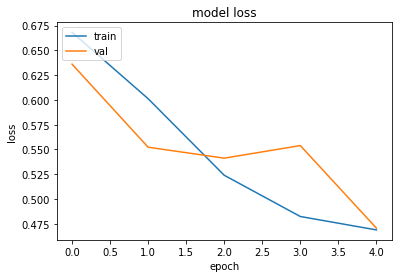

Optimal F1: 0.6687 at threshold: 0.3223
Train on 10592 samples, validate on 2648 samples
Epoch 1/5
 - 25s - loss: 0.6786 - acc: 0.6136 - val_loss: 0.6506 - val_acc: 0.6733

Epoch 00001: val_loss improved from inf to 0.65062, saving model to capsule_net_weights_best.h5
Epoch 2/5
 - 23s - loss: 0.6192 - acc: 0.6672 - val_loss: 0.5562 - val_acc: 0.7273

Epoch 00002: val_loss improved from 0.65062 to 0.55618, saving model to capsule_net_weights_best.h5
Epoch 3/5
 - 23s - loss: 0.5288 - acc: 0.7389 - val_loss: 0.4916 - val_acc: 0.7681

Epoch 00003: val_loss improved from 0.55618 to 0.49160, saving model to capsule_net_weights_best.h5
Epoch 4/5
 - 23s - loss: 0.4927 - acc: 0.7680 - val_loss: 0.4715 - val_acc: 0.7779

Epoch 00004: val_loss improved from 0.49160 to 0.47153, saving model to capsule_net_weights_best.h5
Epoch 5/5
 - 23s - loss: 0.4775 - acc: 0.7804 - val_loss: 0.4623 - val_acc: 0.7847

Epoch 00005: val_loss improved from 0.47153 to 0.46231, saving model to capsule_net_weights_bes

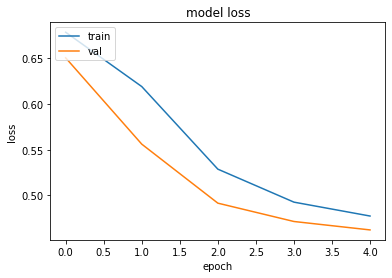

Optimal F1: 0.6850 at threshold: 0.2821


<Figure size 432x288 with 0 Axes>

In [ ]:
kfold = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
bestscore = []
y_test = np.zeros((x_test.shape[0], ))
for i, (train_index, valid_index) in enumerate(kfold.split(x_train, labels)):
    X_train, X_val, Y_train, Y_val = x_train[train_index], x_train[valid_index], labels[train_index], labels[valid_index]
    filepath="capsule_net_weights_best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=1, min_lr=0.0001, verbose=2)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=2, mode='auto')
    callbacks = [checkpoint, reduce_lr]
    model = capsule()
    if i == 0:print(model.summary()) 
    #model.fit(X_train, Y_train, batch_size=64, epochs=5, validation_data=(X_val, Y_val), verbose=2, callbacks=callbacks, )
    history = model.fit(X_train, Y_train, batch_size=64, epochs=5, validation_data=(X_val, Y_val), verbose=2, callbacks=callbacks, 
          )
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.savefig('image' + str(i) + '.png')

    model.load_weights(filepath)
    y_pred = model.predict([X_val], batch_size=64, verbose=2)
    y_test += np.squeeze(model.predict([x_test], batch_size=64, verbose=2))/5
    f1, threshold = f1_smart(np.squeeze(Y_val), np.squeeze(y_pred))
    print('Optimal F1: {:.4f} at threshold: {:.4f}'.format(f1, threshold))
    bestscore.append(threshold)

Converting the predictions for integer.

In [ ]:
y_test = y_test.reshape((-1, 1))
pred_test_y = (y_test>np.mean(bestscore)).astype(int)
test_data['predictions'] = label_encoder.inverse_transform(pred_test_y)

# save predictions
file_path = 'nlp595\predictions.tsv'
test_data.to_csv(file_path, sep='\t', encoding='utf-8')

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test_data["subtask_a"], test_data['predictions']).ravel()
cm = confusion_matrix(test_data["subtask_a"], test_data['predictions'])
(tn, fp, fn, tp)

(547, 73, 70, 170)

In [ ]:
cm = confusion_matrix(test_data["subtask_a"], test_data['predictions'])

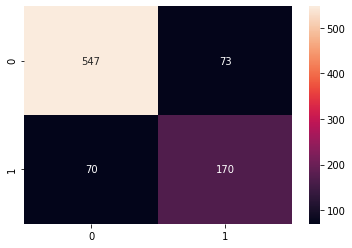

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g')


### Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_data["subtask_a"], test_data['predictions'])

0.8337209302325581

### Macro F1 

In [ ]:
from sklearn.metrics import f1_score
f1_score(test_data["subtask_a"], test_data['predictions'], labels=None, pos_label=1, average='macro', sample_weight=None)

0.7941657419355919

Inspired from: https://github.com/TharinduDR/Aggression-Identification
